# Initial setups

### Installing the missing 'pytesseract' package

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,801 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

### Importing libs

In [2]:
import cv2
import imutils

import numpy as np
import matplotlib.pyplot as plt


from skimage.io import imread
from google.colab.patches import cv2_imshow

## Mounting

In [46]:
import os

TARGET_PATH = '/content/drive/MyDrive/HTTTTM-2/Final Term';
CURRENT_DIR = os.path.abspath(os.curdir)

print('current dir:', CURRENT_DIR)


if TARGET_PATH != CURRENT_DIR:
  os.chdir(TARGET_PATH)


print('\nContaining:\n')
print('\n'.join(os.listdir()))

current dir: /content/drive/My Drive/HTTTTM-2/Final Term

Containing:

images
FeatureExtractor.ipynb
dataset
CNN
Logistic Regression
ImageCrawler.ipynb
Main.ipynb
time: 14.1 ms (started: 2021-07-22 03:12:29 +00:00)


# Inheriting from Main.ipynb

In [7]:
%run Main.ipynb




Training data: (697932, 784) float32 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Testing data: (116323, 784) float32 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Tranining classes (697932, 1) uint8 
 [[35]
 [36]
 [ 6]
 ...
 [ 5]
 [11]
 [22]]

Testing classes (116323, 1) uint8 
 [[18]
 [36]
 [ 0]
 ...
 [28]
 [ 0]
 [ 5]]
time: 23.2 s (started: 2021-07-22 02:22:49 +00:00)


# Load the saved CNN model

In [8]:
from keras.models import load_model, model_from_json

json_file = open('CNN/model.json', mode='r')
json_content = json_file.read()
json_file.close()

the_model = model_from_json(json_content)
the_model.load_weights('CNN/model.h5')

time: 5.25 s (started: 2021-07-22 02:23:13 +00:00)


# Defining functions

In [32]:
def get_image(index):
  return imread(f"images/{index}.jpg")

time: 1.94 ms (started: 2021-07-22 02:58:49 +00:00)


## Graying the image

In [10]:
def to_gray(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

time: 1.04 ms (started: 2021-07-22 02:23:18 +00:00)


## Finding contours

In [11]:
def get_highlighted_image(grayed_image):
  # highlighting the letter contours
  thresh = cv2.threshold(grayed_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]


  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)


  contour_coordinates = []
  for contour in contours:
    contour_coordinates.append(cv2.boundingRect(contour))

  # sorting the contours array to ensure the numbers is from left-to-right (keeping the original order)
  contour_coordinates = sorted(contour_coordinates, key=lambda tupl: tupl[0])

  return thresh, contour_coordinates

time: 9.03 ms (started: 2021-07-22 02:23:18 +00:00)


## Drawing bounding boxes

In [12]:
# drawing bouding boxes for each found-contour

def draw_bounding_boxes(highlighted_img, contour_coordinates):

  for coordinate in contour_coordinates:
    (x, y, w, h) = coordinate
    # drawing a rectangle
    highlighted_img = cv2.rectangle(highlighted_img, (x, y), (x+w, y+h), (0, 0, 255), 1)

    # cropping the letter image
    cropped = image[(y-3):(y+h+3), (x):(x+w+1)]
    print(coordinate, end='')
    cv2_imshow(cropped)
    print('\n')

  cv2_imshow(highlighted_img)

time: 12.3 ms (started: 2021-07-22 02:23:18 +00:00)


## Resizing image to 28×28 by padding black border

In [33]:
def scale(img):
  return cv2.resize(img, (20, 20), interpolation = cv2.INTER_AREA)


def image_resize(img):
  img = scale(img)

  IMG_COL=28
  IMG_ROW=28

  top =  int((IMG_ROW - img.shape[0]) / 2)
  bottom = IMG_ROW - img.shape[0] - top

  left =  int((IMG_COL - img.shape[1]) / 2)
  right = IMG_COL -img.shape[1] - left

  # print('scaled.shape:', img.shape)
  # print('top, bottom, left, right:', top, bottom, left, right)

  padded = cv2.copyMakeBorder(img.copy(), top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
  return padded


time: 15.6 ms (started: 2021-07-22 03:04:54 +00:00)


## Predict function

In [54]:
def predict(highlighted_img, contour_coordinates, verbose=False) -> str:
  result = list()

  for i, ctr in enumerate(contour_coordinates):
      # Get bounding box
      x, y, w, h = ctr

      # print('w, h:', w, h)

      # Getting letter from the image by coordinates
      letter_img = highlighted_img[y:y+h, x-1:x+w+1]
      # cv2_imshow(letter_img)

      # resizing to 28×28
      letter_img = image_resize(letter_img)

      if verbose:
        cv2_imshow(letter_img)
        # print(letter_img.shape)
        # print('\n\n')


      # converting the image to numpy array
      t = np.copy(np.array(letter_img))
      t = t / 255.0
      t = t.reshape(1, 784)

      # predicting
      pred = the_model.predict_classes(t)
      character = get_character(pred[0])
      result.append(character)

  return ''.join(list(map(lambda arr: arr[0], result)))

time: 23.6 ms (started: 2021-07-22 03:16:17 +00:00)


# Let's predict

## Test on one image

In [57]:
image = get_image(1)
grayed = to_gray(image)

# *get_highlighted_image(x): the * symbol is for tuple unpacking from the function returning 
predict(*get_highlighted_image(grayed), verbose=True)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'49518'

time: 263 ms (started: 2021-07-22 03:21:19 +00:00)


## Bulk run on the images

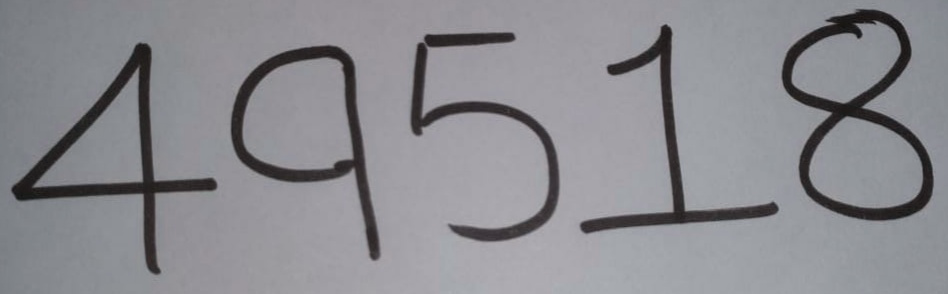

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Result: 49518 




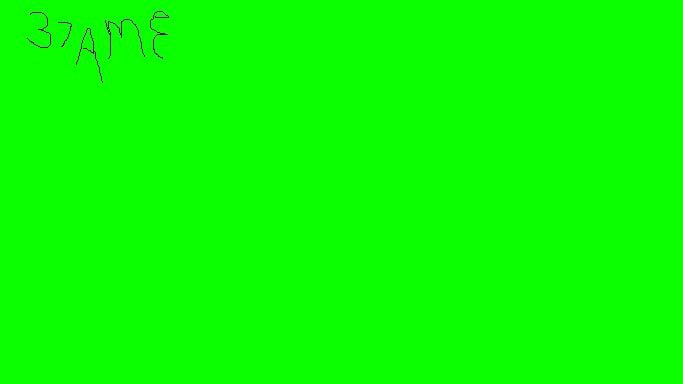

Result: 3711E 




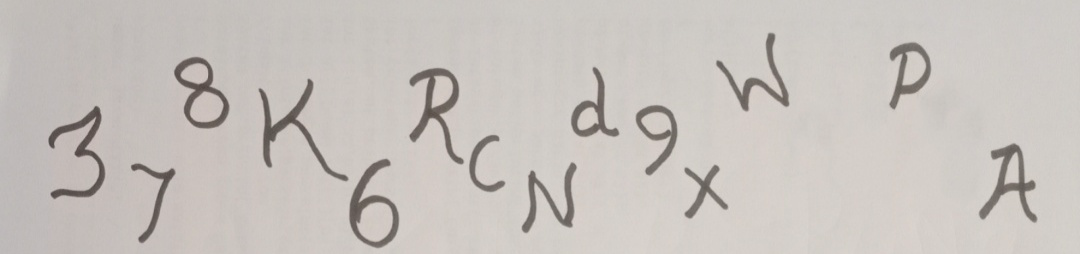

Result: 378K6RCNd9XWPA 




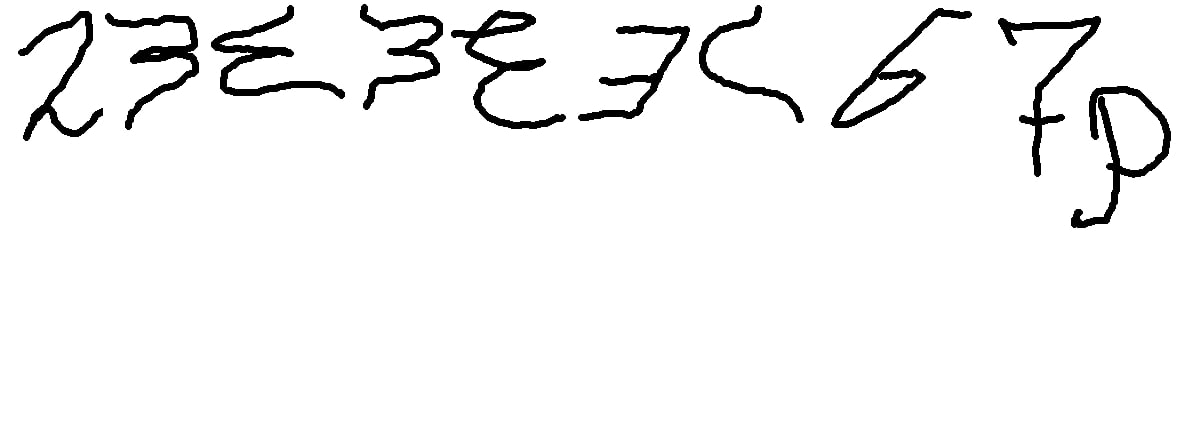

Result: 2PE3E3C67P 




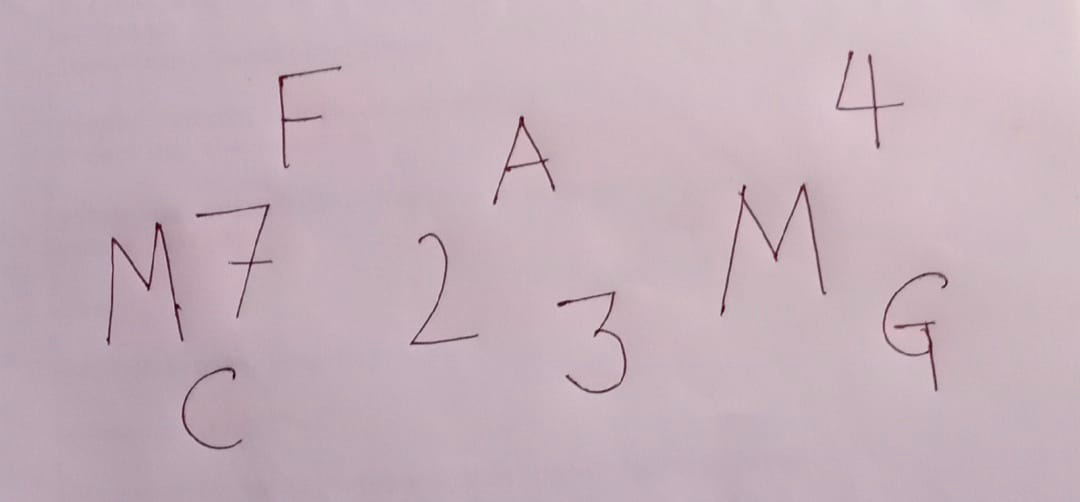

Result: MC7F2A314F 




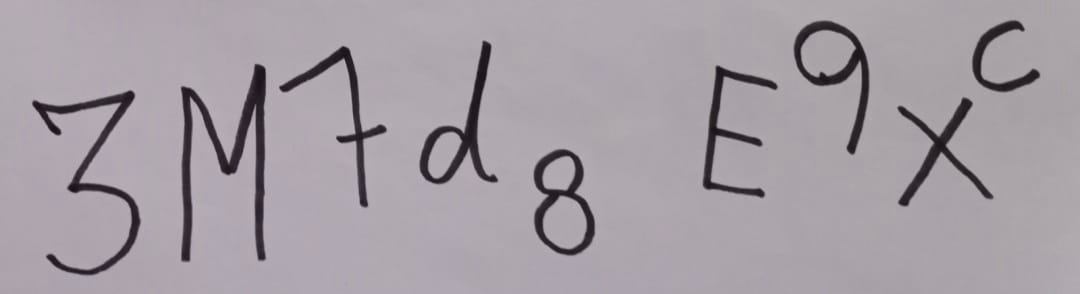

Result: 3M7d8E9XC 




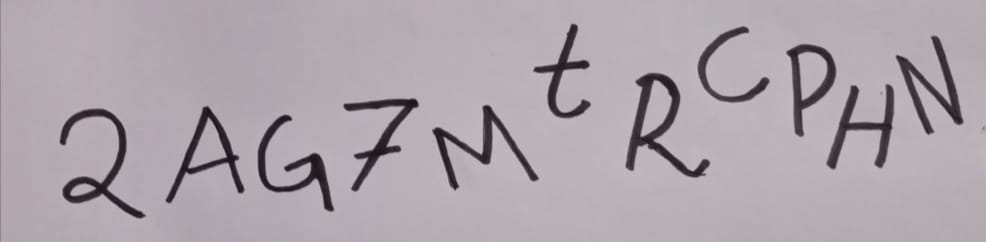

Result: 2AG7MtRCPHN 




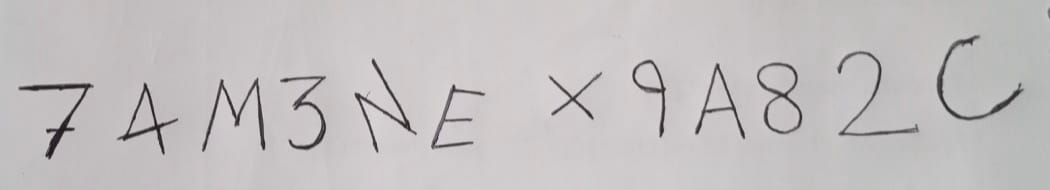

Result: 74M32IEx9A82Cq 




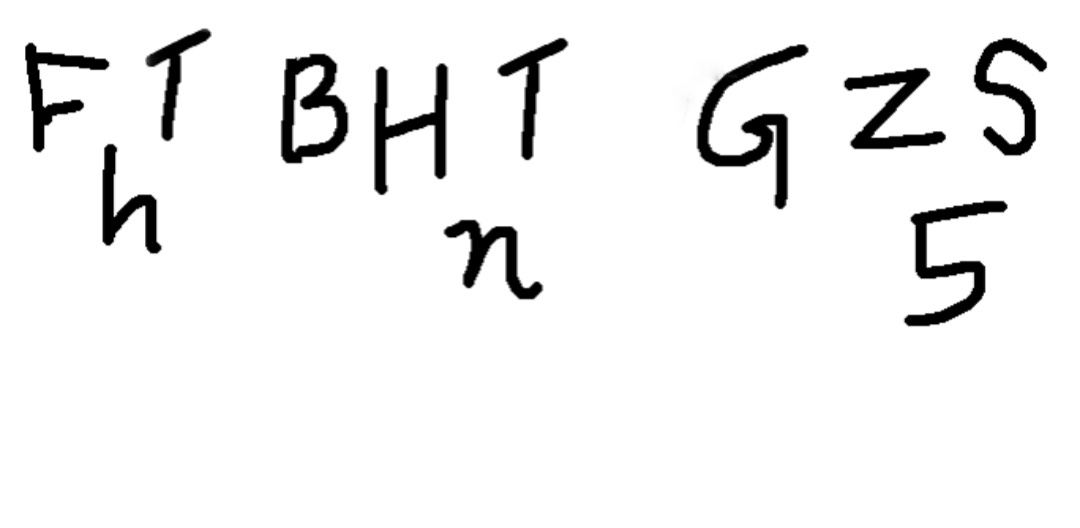

Result: FhTBHnTGZ5S 




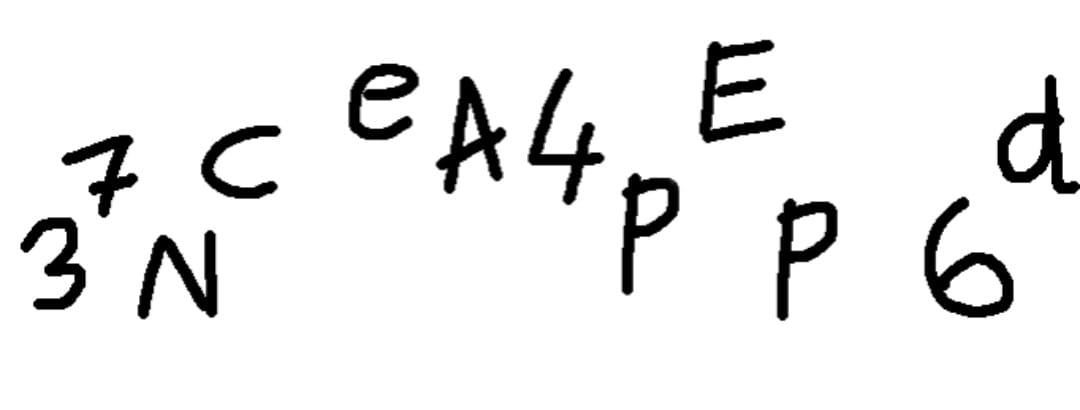

Result: 37NCeA4PEP6d 




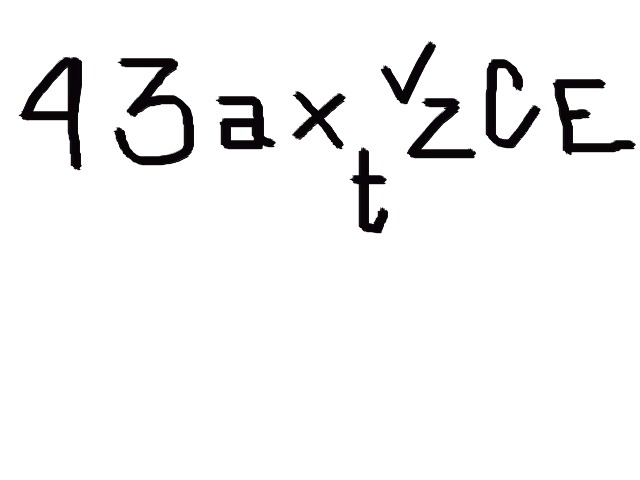

Result: 43aXtVZCE 




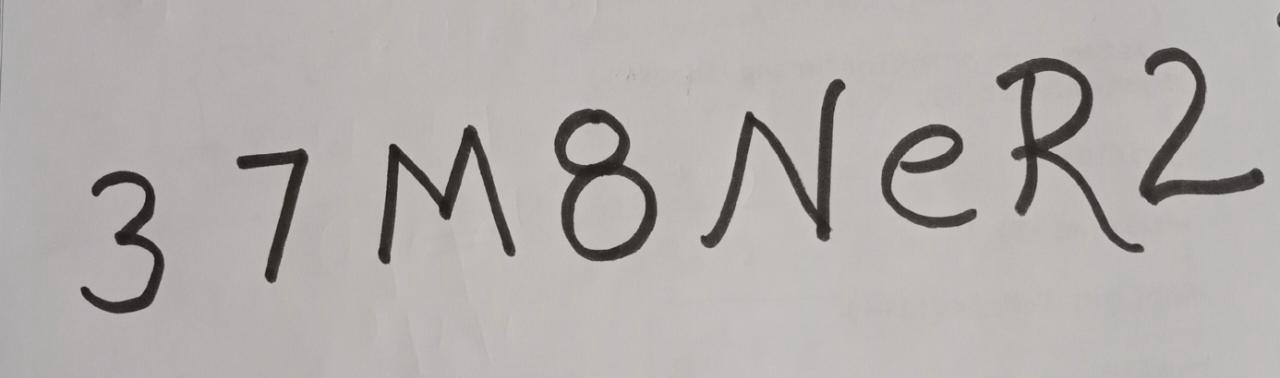

Result: 37M8NeR2a 




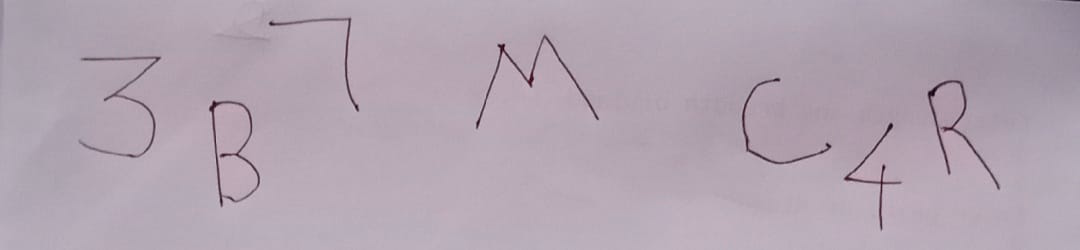

Result: 3311Ct97 




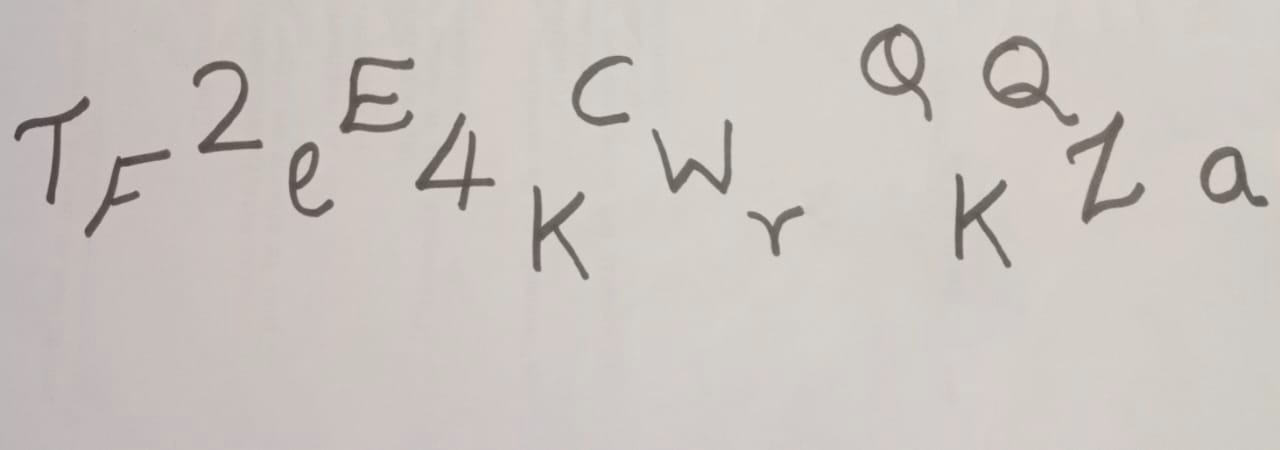

Result: TF2eE4KCWrQKQ2a 


time: 8.72 s (started: 2021-07-22 03:16:28 +00:00)


In [56]:
images_count = len(os.listdir('images/'))

for i in range(1, images_count + 1):
  image = get_image(i)
  cv2_imshow(image)

  grayed = to_gray(image)
  str_result = predict(*get_highlighted_image(grayed), verbose=True)

  print('Result:', str_result, '\n\n')
